In [61]:
from time import time
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import pandas as pd
import xarray as xr

import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
import jax.tree_util as jtu

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from delhi_aq.my_nn import SIREN, fit, NeRF
from delhi_aq.my_utils import pool_image, get_coords_for_image

import matplotlib.pyplot as plt
from multiprocessing import Pool

In [62]:
seed = 1
aq_data = xr.open_dataset("../processed_data/delhi_cpcb_2022_cleaned.nc").to_dataframe().reset_index().set_index("time", drop=False)
aq_data = aq_data["2022"]
print(aq_data.columns)
all_stations = aq_data.dropna(subset="PM2.5").station.unique()

Index(['station', 'time', 'From Date', 'To Date', 'PM2.5', 'PM10', 'NO', 'NO2',
       'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'AT', 'RF', 'TOT-RF', 'latitude', 'longitude'],
      dtype='object')


/tmp/ipykernel_2024695/328091300.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  aq_data = aq_data["2022"]


In [63]:
aq_data.shape[0]/39

8760.0

In [64]:
result_df = aq_data.drop_duplicates(subset=["station"]).set_index("station")[["latitude", "longitude"]]
def load_and_process_data(station):
    # print("###############")
    # print(f"Station: {station}")
    # print("###############")
    timeseries = aq_data[aq_data["station"] == station][['From Date', 'PM2.5']]
    init_len = timeseries.shape[0]
    timeseries['x'] = np.linspace(-1, 1, init_len)
    timeseries.dropna(subset=["PM2.5"], inplace=True)
    final_len = timeseries.shape[0]
    missing_data_frac = 1 - final_len/init_len
    # print(f"Initial length={init_len}, Final length={final_len}, missing data frac={missing_data_frac:.2f}")
    
    x = timeseries['x'].values.reshape(-1, 1)
    y = timeseries['PM2.5'].values.reshape(-1, 1)
    train_val_x_, test_x_, train_val_y_, test_y_ = train_test_split(x, y, test_size=0.2, random_state=seed+1)
    train_x_, val_x_, train_y_, val_y_ = train_test_split(train_val_x_, train_val_y_, test_size=0.2, random_state=seed+2)
    return train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac
    
def run(station, gpu_id):
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac = load_and_process_data(station)
    x_scaler = MinMaxScaler((-1, 1))
    y_scaler = MinMaxScaler((-1, 1))
    train_x = x_scaler.fit_transform(train_x_)
    val_x = x_scaler.transform(val_x_)
    test_x = x_scaler.transform(test_x_)
    train_y = y_scaler.fit_transform(train_y_)
    val_y = y_scaler.transform(val_y_)
    test_y = y_scaler.transform(test_y_)
    # print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)
    
    model = SIREN(n_hidden_layer_neurons=[256, 256, 256, 256], output_shape=train_y_.shape[-1], activation_scale=30.0)
    config = {"lr": 1e-4, "batch_size":-1, "iterations":10000}
    params, old_params_history, train_losses, val_losses, test_losses = fit(jax.random.PRNGKey(seed+3), model, 
                                                                            train_x, train_y, config, val_x, val_y, test_x, test_y)
    
    # plt.plot(train_losses, label="train")
    # plt.plot(val_losses, label="val")
    # plt.plot(test_losses, label="test")
    # plt.legend();
    
    best_val_idx = jnp.argmin(val_losses)
    best_params = jtu.tree_map(lambda x: x[best_val_idx], old_params_history)

    pred_y = model.apply(best_params, test_x).__array__()
    pred_y_ = y_scaler.inverse_transform(pred_y)
    # plt.scatter(test_y_, pred_y_)
    # plt.plot([0, 500], [0, 500], color="r", linestyle="--");

    rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    return station, rmse, missing_data_frac

# run the above function parallely on 4 GPUs using multiprocessing
# I want to dynamically allocate GPUs as they become available

init = time()
pool = Pool(4)
results = []
for station in tqdm(all_stations):
    gpu_id = len(results) % 4
    results.append(pool.apply_async(run, args=(station, gpu_id)))
pool.close()
pool.join()

# results = [r.get() for r in results]
result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
result_df.to_csv("results/temporal_interpolation_SIREN.csv")
print(f"Time taken: {(time() - init)/60:.2f} mins")

100%|██████████| 39/39 [00:00<00:00, 89927.35it/s]


Time taken: 1.27 mins


## NeRF

In [65]:
result_df = aq_data.drop_duplicates(subset=["station"]).set_index("station")[["latitude", "longitude"]]
def load_and_process_data(station):
    # print("###############")
    # print(f"Station: {station}")
    # print("###############")
    timeseries = aq_data[aq_data["station"] == station][['From Date', 'PM2.5']]
    init_len = timeseries.shape[0]
    timeseries['x'] = np.linspace(-1, 1, init_len)
    timeseries.dropna(subset=["PM2.5"], inplace=True)
    final_len = timeseries.shape[0]
    missing_data_frac = 1 - final_len/init_len
    # print(f"Initial length={init_len}, Final length={final_len}, missing data frac={missing_data_frac:.2f}")
    
    x = timeseries['x'].values.reshape(-1, 1)
    y = timeseries['PM2.5'].values.reshape(-1, 1)
    train_val_x_, test_x_, train_val_y_, test_y_ = train_test_split(x, y, test_size=0.2, random_state=seed+1)
    train_x_, val_x_, train_y_, val_y_ = train_test_split(train_val_x_, train_val_y_, test_size=0.2, random_state=seed+2)
    return train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac
    
def run(station, gpu_id):
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac = load_and_process_data(station)
    x_scaler = MinMaxScaler((-1, 1))
    y_scaler = MinMaxScaler((-1, 1))
    train_x = x_scaler.fit_transform(train_x_)
    val_x = x_scaler.transform(val_x_)
    test_x = x_scaler.transform(test_x_)
    train_y = y_scaler.fit_transform(train_y_)
    val_y = y_scaler.transform(val_y_)
    test_y = y_scaler.transform(test_y_)
    # print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)
    
    model = NeRF(n_hidden_layer_neurons=[256, 256, 256, 256], output_shape=train_y_.shape[-1], activation="relu")
    config = {"lr": 1e-4, "batch_size":-1, "iterations":10000}
    params, old_params_history, train_losses, val_losses, test_losses = fit(jax.random.PRNGKey(seed+3), model, 
                                                                            train_x, train_y, config, val_x, val_y, test_x, test_y)
    
    # plt.plot(train_losses, label="train")
    # plt.plot(val_losses, label="val")
    # plt.plot(test_losses, label="test")
    # plt.legend();
    
    best_val_idx = jnp.argmin(val_losses)
    best_params = jtu.tree_map(lambda x: x[best_val_idx], old_params_history)

    pred_y = model.apply(best_params, test_x).__array__()
    pred_y_ = y_scaler.inverse_transform(pred_y)
    # plt.scatter(test_y_, pred_y_)
    # plt.plot([0, 500], [0, 500], color="r", linestyle="--");

    rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    return station, rmse, missing_data_frac

# run the above function parallely on 4 GPUs using multiprocessing
# I want to dynamically allocate GPUs as they become available

init = time()
pool = Pool(4)
results = []
for station in tqdm(all_stations):
    gpu_id = len(results) % 4
    results.append(pool.apply_async(run, args=(station, gpu_id)))
pool.close()
pool.join()

# results = [r.get() for r in results]
result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
result_df.to_csv("results/temporal_interpolation_ReLU-NN.csv")
print(f"Time taken: {(time() - init)/60:.2f} mins")

100%|██████████| 39/39 [00:00<00:00, 95436.32it/s]


Time taken: 1.17 mins


## RF

In [66]:
def run(station):
    train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac = load_and_process_data(station)
    # train_val_x_ = np.concatenate([train_x_, val_x_], axis=0)
    # train_val_y_ = np.concatenate([train_y_, val_y_], axis=0)
    
    model = RandomForestRegressor(n_estimators=1000, random_state=seed)
    model.fit(train_x_, train_y_.ravel())
    pred_y_ = model.predict(test_x_)
    
    rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    return station, rmse, missing_data_frac

init = time()
pool = Pool(32)
results = []
for station in tqdm(all_stations):
    results.append(pool.apply_async(run, args=(station,)))
pool.close()
pool.join()

result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
result_df.to_csv("results/temporal_interpolation_RF.csv")
print(f"Time taken: {(time() - init)/60:.2f} mins")

100%|██████████| 39/39 [00:00<00:00, 109636.63it/s]


Time taken: 0.21 mins


## GB

In [67]:
def run(station):
    train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac = load_and_process_data(station)
    # train_val_x_ = np.concatenate([train_x_, val_x_], axis=0)
    # train_val_y_ = np.concatenate([train_y_, val_y_], axis=0)
    
    model = GradientBoostingRegressor(n_estimators=1000, random_state=seed)
    model.fit(train_x_, train_y_.ravel())
    pred_y_ = model.predict(test_x_)
    
    rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    return station, rmse, missing_data_frac

init = time()
pool = Pool(32)
results = []
for station in tqdm(all_stations):
    results.append(pool.apply_async(run, args=(station,)))
pool.close()
pool.join()

result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
result_df.to_csv("results/temporal_interpolation_GB.csv")
print(f"Time taken: {(time() - init)/60:.2f} mins")

100%|██████████| 39/39 [00:00<00:00, 110301.99it/s]


Time taken: 0.08 mins


## Plotting

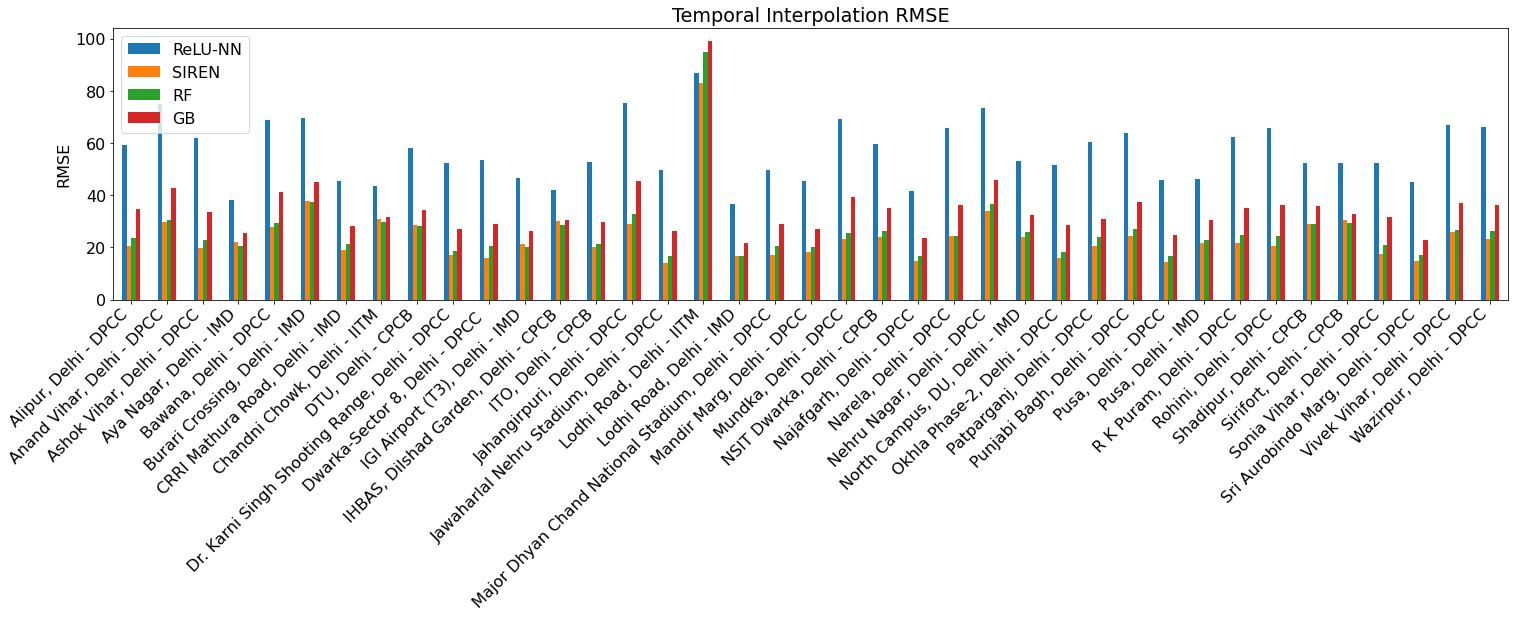

In [70]:
result_df = pd.DataFrame(index=all_stations)
models = ["ReLU-NN", "SIREN", "RF", "GB"]
for model in models:
    df = pd.read_csv(f"results/temporal_interpolation_{model}.csv").set_index("station")
    result_df[model] = df["rmse"]

# plot the results as bar chart
result_df.plot.bar(figsize=(25, 5), rot=0, title="Temporal Interpolation RMSE", ylabel="RMSE");
# rotate the xticks
plt.xticks(rotation=45, ha="right");

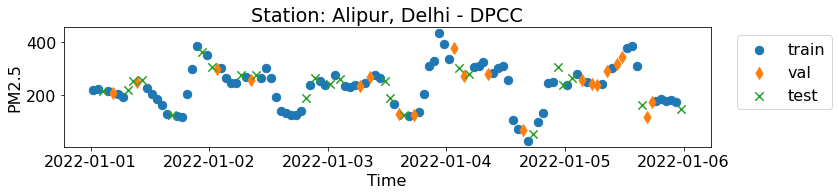

In [73]:
s1 = aq_data.station.unique()[0]
df = aq_data[aq_data.station == s1]["2022-01-01":"2022-01-05"][["time", "PM2.5"]]

train_val_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=0)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, shuffle=True, random_state=0)
train_df = train_df.sort_index()
val_df = val_df.sort_index()
test_df = test_df.sort_index()

s = 70
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 3))
plt.scatter(train_df.time, train_df["PM2.5"], label="train", s=s)
plt.scatter(val_df.time, val_df["PM2.5"], label="val", s=s, marker="d")
plt.scatter(test_df.time, test_df["PM2.5"], label="test", s=s, marker="x")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend(bbox_to_anchor=(1.2, 1));
plt.title(f"Station: {s1}")
plt.tight_layout()